# Setup

In [1]:
import imageio
import glob
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image
from scipy import linalg
import numpy as np
import os
import math

home_path = '/home/balazs/Documents/GeomDataSci/HW5'
data_path = home_path + '/data'
face_path = data_path + '/faces'

In [2]:
# normalize an image so all pixels ar in [0,1]
def normalize(im):
    m = np.max(im)
    n = np.min(im)
    return np.array([(p-n)/(m-n) for p in im])

In [3]:
## Load training images
num=1640
dim=50
images = np.zeros((num, dim*dim))

for i in range(0,num):
    filename = os.path.join(face_path, str(i+1)+".png" )
    A=img.imread(filename)
    images[i,...] = A.reshape((1,-1))
    
for i in range(0,num):
    images[i] = normalize(images[i])

images = np.delete(images, 10, 0)
num = num-1

(1639, 2500)


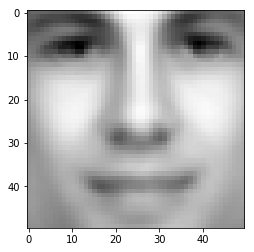

In [4]:
## Average face
avg_image = np.mean(images, axis=0)
plt.imshow(np.array(np.reshape(avg_image,(dim,dim)),dtype='float'), cmap='gray')
print(images.shape)

# AM-RR implementation

In [5]:
# reconstruct an image given weights
def reconstruct(X, w):
    data = X
    if (len(w) != X.shape[0]):
        data = X.transpose()
    ct = data.shape[0]
    
    image = np.zeros(data.shape[1])
    for i in range(ct):
        image = np.sum([image, w[i]*data[i]], axis=0)
        
    return image

In [6]:
# draw a face as an image
def draw_face(face):
    plt.figure()
    plt.imshow(face.reshape(dim,dim), cmap='gray')

In [7]:
# draw set of corrupted pixels
def draw_s(s, n):
    image = np.zeros(n)
    for i in s:
        image[i] = 1
    draw_face(image)

In [8]:
# AM-RR implementation
# X: training data
# y: input image
# k: |corruption|
# s: sparsity constraint (-1 for no constraint)
# it: iterations

def AMRR(X, y, k, s, it):
    n = X.shape[1] # dimensionality
    p = X.shape[0] # number of training points
    cur_w = np.zeros(p)
    k = int(k)
    
    cur_s = list(range(n-k))
    tr_X = np.transpose(X)
    
    for t in range(1, it):
        # potentially transpose x_sub
        Xs = tr_X[cur_s].transpose()
        ys = y[cur_s]
        
        # find best fit weights
        w_appr = np.dot(np.matmul(np.linalg.inv(np.matmul(Xs,Xs.transpose())),Xs),ys)
        
        # sparsity constraint on w
        if (s > 0):
            # get indices of s largest weights in O(p + slogs)
            ind = np.argpartition(np.absolute(w_appr), -s)[-s:]
            
            # iterative thresholding
            Xs = Xs[ind]
            
            # find best fit weights
            w_appr = np.dot(np.matmul(np.linalg.inv(np.matmul(Xs,Xs.transpose())),Xs),ys)
            
            new_w = np.zeros(p)
            for i in range(s):
                new_w[ind[i]] = w_appr[i]
        else:
            new_w = w_appr

        # find best fitted pixels
        cur_im = reconstruct(X, new_w)
        
        cur_dif = [(y[i] - cur_im[i])**2 for i in range(n)]
        new_s = np.argpartition(cur_dif, (n-k))[:(n-k)]
        
        # update for next iteration
        cur_w = new_w
        cur_s = new_s
        
    return cur_w, cur_s

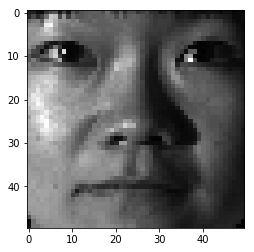

In [9]:
# test our code on a training image
test_im = images[275]
draw_face(test_im)

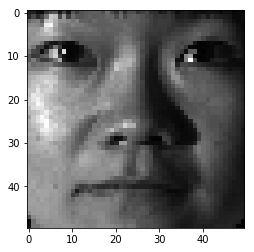

In [10]:
rec_w, pix = AMRR(images, test_im, 100, -1, 10)
draw_face(reconstruct(images, rec_w))

# Recovery of corrupted images

In [11]:
c_num = 3
corrupted_ims = np.zeros((c_num, dim*dim))
corrupted_meta = np.zeros((c_num, 2))

# find character indices in string
def find(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch]

# load images and metadata
i = 0
for filename in glob.glob(data_path+"/*.jpg"):
    if (i >= c_num):
        break
    A=img.imread(filename)
    corrupted_ims[i,...] = A.reshape((1,-1))
    
    pos = find(filename, '_')
    meta1 = int(filename[pos[-2]+1:pos[-1]])
    meta2 = int(filename[pos[-1]+1:-4])
    corrupted_meta[i] = [meta1, meta2]
    
    i += 1
    
for i in range(len(corrupted_ims)):
    corrupted_ims[i] = normalize(corrupted_ims[i])

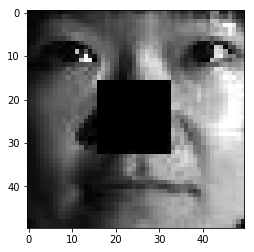

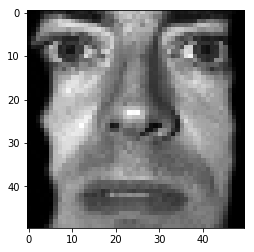

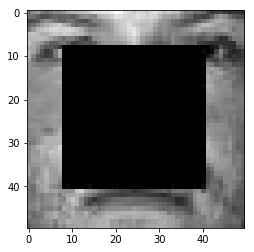

In [12]:
# draw corrupted images
for im in corrupted_ims:
    draw_face(im)

# Image recovery algorithm

In [13]:
def recover_images(data, images, image_meta, sparsity, iterations):
    c_num = len(images)
    recovered = np.zeros((c_num, dim*dim))
    corruption = np.zeros((c_num, dim*dim))

    # run AMRR
    for i in range(c_num):
        rec_w, pix = AMRR(data, images[i], image_meta[i][1]*0.01*dim*dim, sparsity, iterations)

        corr = np.zeros(dim*dim)
        for j in pix:
            corr[j] = 1

        recovered[i] = reconstruct(data, rec_w)
        corruption[i] = corr
        
    # visualize results
    plt.figure(figsize=(15, 15))
    f, ax = plt.subplots(c_num,4, gridspec_kw = {'wspace':0, 'hspace':0})
    for i, axis in enumerate(f.axes):
        axis.set_xticklabels([])
        axis.set_yticklabels([])

    for i in range(c_num):
        ori = data[int(image_meta[i][0])-1].reshape(dim,dim)
        corr = images[i].reshape(dim,dim)
        rec = recovered[i].reshape(dim,dim)
        pix = corruption[i].reshape(dim,dim)

        ax[i, 0].imshow(ori, cmap='gray')
        ax[i, 1].imshow(corr, cmap='gray')
        ax[i, 2].imshow(rec, cmap='gray')
        ax[i, 3].imshow(pix, cmap='gray')


    ax[0,0].set_title("original")
    ax[0,1].set_title("corrupted")
    ax[0,2].set_title("recovered")
    ax[0,3].set_title("noise")
    plt.tight_layout()
    plt.show()

# Recovery without sparsity constraints

<Figure size 1080x1080 with 0 Axes>

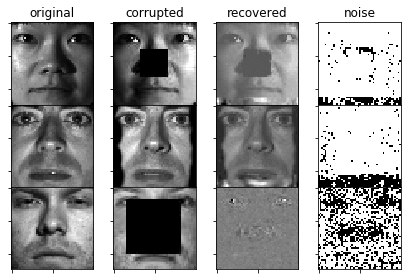

In [14]:
recover_images(images, corrupted_ims, corrupted_meta, -1, 100)

# Recovery with sparsity k=100

<Figure size 1080x1080 with 0 Axes>

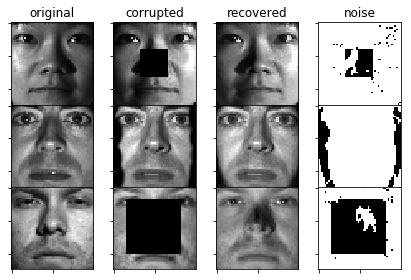

In [15]:
recover_images(images, corrupted_ims, corrupted_meta, 100, 100)

# Recovery with sparsity k=25

<Figure size 1080x1080 with 0 Axes>

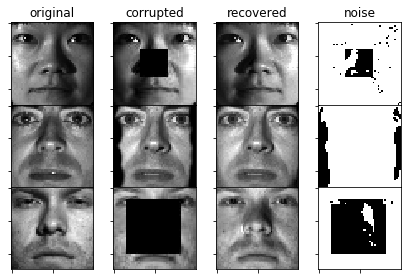

In [16]:
recover_images(images, corrupted_ims, corrupted_meta, 25, 50)

# Recovery with sparsity k=10

<Figure size 1080x1080 with 0 Axes>

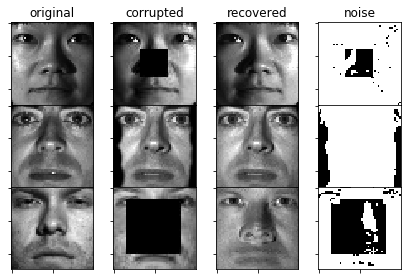

In [17]:
recover_images(images, corrupted_ims, corrupted_meta, 10, 50)

# Recovery with sparsity k=5

<Figure size 1080x1080 with 0 Axes>

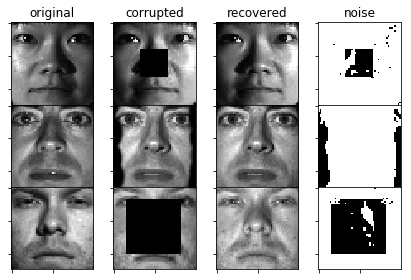

In [18]:
recover_images(images, corrupted_ims, corrupted_meta, 5, 50)

# Recovery with sparsity k=2

<Figure size 1080x1080 with 0 Axes>

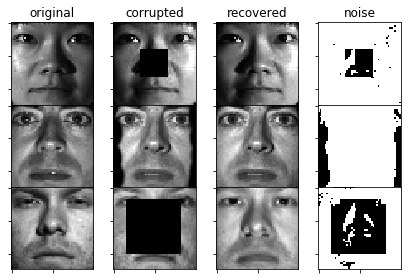

In [19]:
# With very strong sparsity, convengence is much faster
recover_images(images, corrupted_ims, corrupted_meta, 2, 10)